In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Lectura de datos

In [2]:
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
air_passengers_df.columns = ["time", "value"]
air_passengers_df.head()


,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## First study

In [4]:
# air_passengers_df.shape
air_passengers_df.describe()
air_passengers_df.dtypes

time     object
value     int64
dtype: object

,count,mean,std,min,25%,50%,75%,max
PageLoads,2167.0,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
UniqueVisits,2167.0,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
FirstTimeVisits,2167.0,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0


## First visualitation

In [6]:
air_passengers_ts = TimeSeriesData(air_passengers_df)

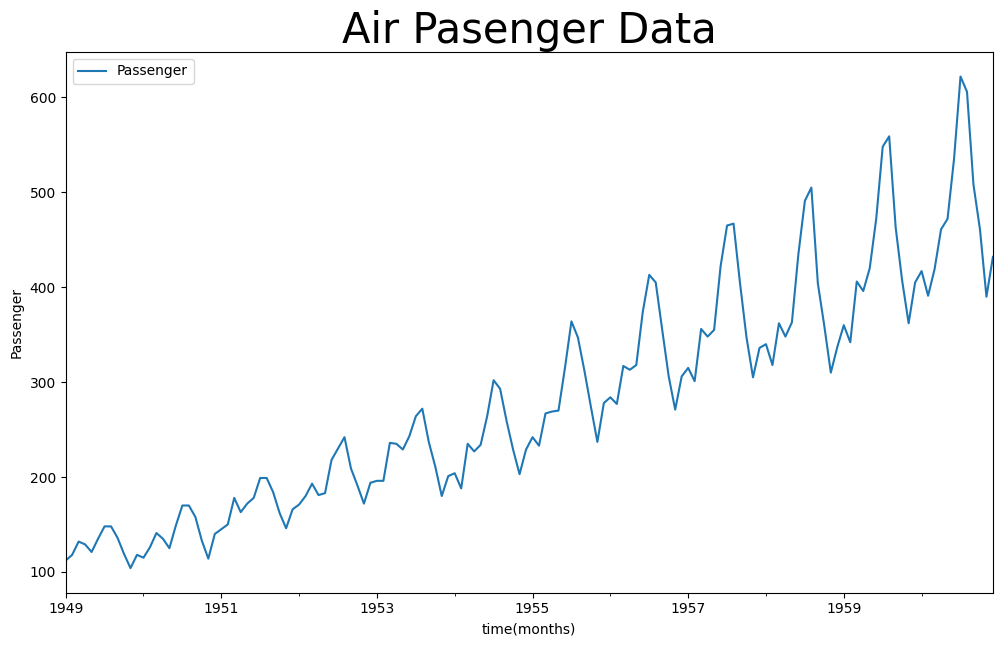

In [7]:
%matplotlib inline

# Must pass the name of the value columns to plot
air_passengers_ts.plot(cols=['value'])
plt.title('Air Pasenger Data', fontsize = 30)
plt.xlabel('time(months)')
plt.ylabel('Passenger')
plt.legend(['Passenger'])
plt.savefig('../images/APD', bbox_inches = 'tight')

# First comparative

## Individual models

In [11]:
## HYPERPARAMETERS
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData


from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

### sarima

In [12]:
from kats.models.sarima import SARIMAModel, SARIMAParams
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
}
# {
#     "name": "seasonal_order",
#     "type": "choice",
#     "values": [(0,0,0,12),(1,1,1,12),(1,0,0,12),(0,1,0,12),(0,0,1,12),(1,1,0,12),(1,0,1,12),(0,1,1,12)],
#     "value_type": "int",
#     "is_ordered": True,
# },
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    sarima_params = SARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = SARIMAModel(train_ts, sarima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,85.254156,0.0,0,"{'p': 1, 'd': 1, 'q': 1}"
1,0_1,evaluation_metric,62.063473,0.0,0,"{'p': 1, 'd': 1, 'q': 2}"
2,0_2,evaluation_metric,126.992591,0.0,0,"{'p': 1, 'd': 2, 'q': 1}"
3,0_3,evaluation_metric,115.322728,0.0,0,"{'p': 1, 'd': 2, 'q': 2}"
4,0_4,evaluation_metric,60.528996,0.0,0,"{'p': 2, 'd': 1, 'q': 1}"
5,0_5,evaluation_metric,63.545311,0.0,0,"{'p': 2, 'd': 1, 'q': 2}"
6,0_6,evaluation_metric,102.744892,0.0,0,"{'p': 2, 'd': 2, 'q': 1}"
7,0_7,evaluation_metric,120.273295,0.0,0,"{'p': 2, 'd': 2, 'q': 2}"


<AxesSubplot: xlabel='time', ylabel='y'>

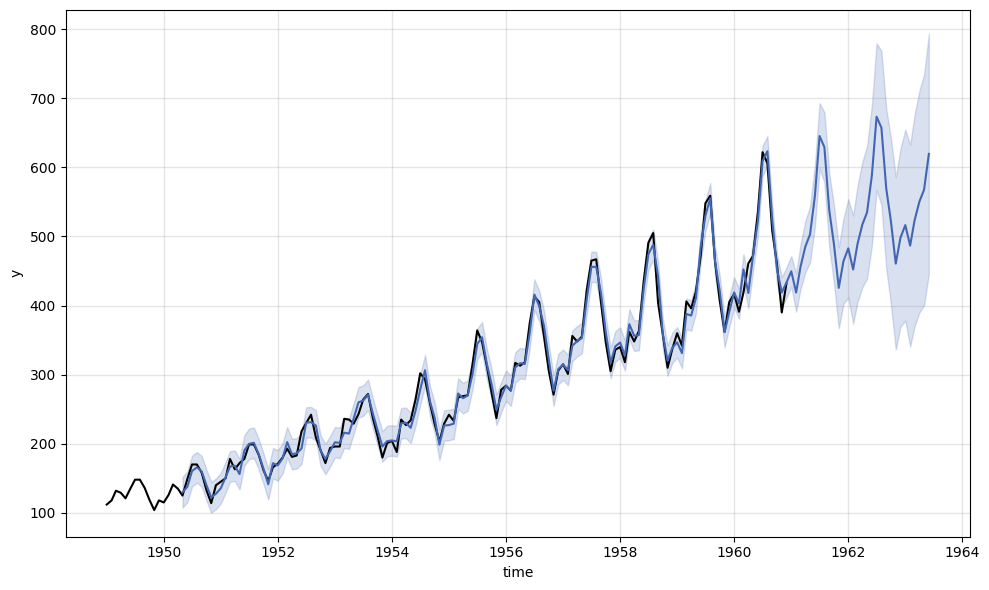

In [13]:
warnings.simplefilter(action='ignore')

# create SARIMA param class
sarima_params = SARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    trend = 'ct', #both linear or constant
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=air_passengers_ts, params=sarima_params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS",
    include_history=True
    )

# make plot to visualize
m.plot()

### arima

In [14]:
from kats.models.arima import ARIMAParams, ARIMAModel
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    arima_params = ARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = ARIMAModel(train_ts, arima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,115.202398,0.0,0,"{'p': 1, 'd': 1, 'q': 1}"
1,0_1,evaluation_metric,54.991706,0.0,0,"{'p': 1, 'd': 1, 'q': 2}"
2,0_2,evaluation_metric,183.296357,0.0,0,"{'p': 1, 'd': 2, 'q': 1}"
3,0_3,evaluation_metric,157.335281,0.0,0,"{'p': 1, 'd': 2, 'q': 2}"
4,0_4,evaluation_metric,52.022001,0.0,0,"{'p': 2, 'd': 1, 'q': 1}"
5,0_5,evaluation_metric,56.345822,0.0,0,"{'p': 2, 'd': 1, 'q': 2}"
6,0_6,evaluation_metric,141.107596,0.0,0,"{'p': 2, 'd': 2, 'q': 1}"
7,0_7,evaluation_metric,165.195943,0.0,0,"{'p': 2, 'd': 2, 'q': 2}"


<AxesSubplot: xlabel='time', ylabel='y'>

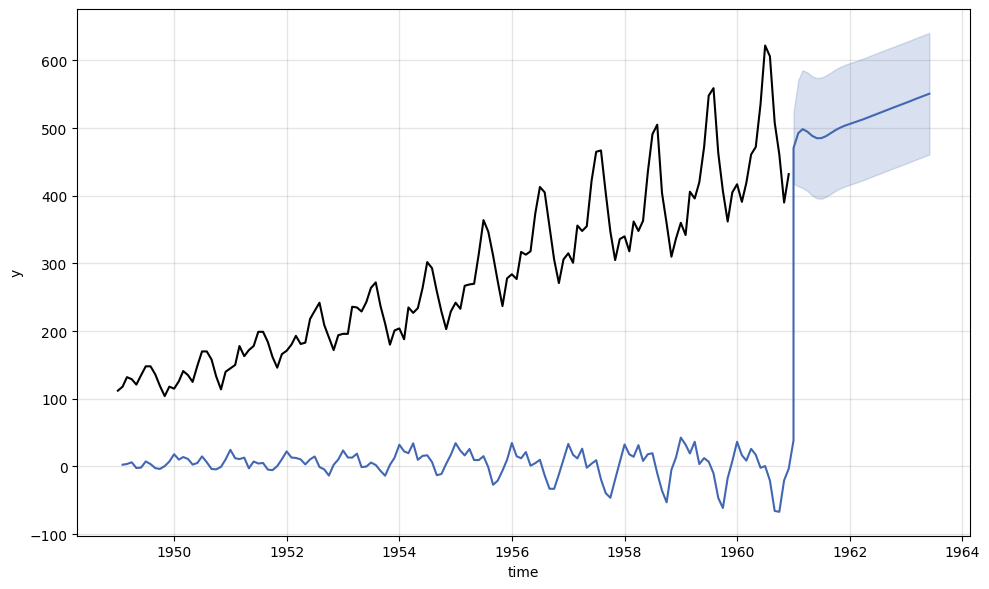

In [15]:
# create ARIMA param class
arima_params = ARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    )

# initiate SARIMA model
m = ARIMAModel(data=air_passengers_ts, params=arima_params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS",
    include_history=True
    )

# make plot to visualize
m.plot()

### prophet

In [16]:
# # import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams
warnings.simplefilter(action='ignore')


parameters_grid_search = [
{
    "name": "seasonality_mode",
    "type": "choice",
    "values": ['additive','multiplicative'],
    "value_type": "str",
    "is_ordered": True,
},
{
    "name": "n_changepoints",
    "type": "choice",
    "values": list(range(10, 30)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "changepoint_range",
    "type": "choice",
    "values": [0.6, 0.7, 0.8, 0.9],
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    prophet_params = ProphetParams(
        seasonality_mode= params['seasonality_mode'],
        n_changepoints= params['n_changepoints'],
        changepoint_range=  params['changepoint_range']
    )
    model = ProphetModel(train_ts, prophet_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using -1.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using -1.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using -1.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
1,0_1,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
2,0_2,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
3,0_3,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
4,0_4,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
5,0_5,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
6,0_6,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
7,0_7,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
8,0_8,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
9,0_9,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot: xlabel='time', ylabel='y'>

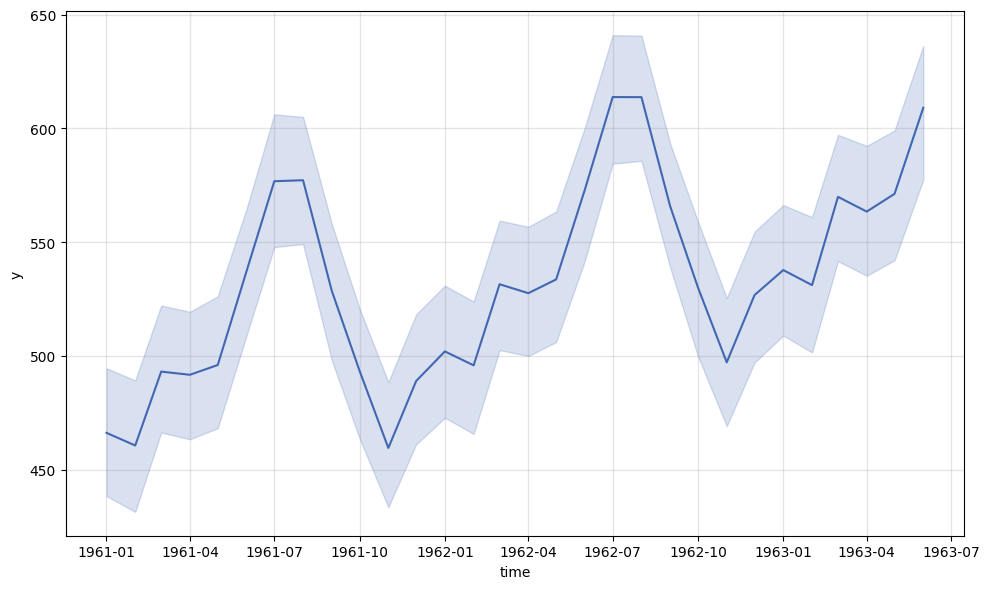

In [17]:
# create a model param instance
prophet_params = ProphetParams(seasonality_mode='additive') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, prophet_params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

# plot to visualize
m.plot()

### holt-winter

In [18]:
from kats.models.holtwinters import HoltWintersModel, HoltWintersParams
parameters_grid_search = [
{
    "name": "trend",
    "type": "choice",
    "values": ['additive','multiplicative'],
    "value_type": "str",
    "is_ordered": True,
},
{
    "name": "damped",
    "type": "choice",
    "values": [True, False],
    "value_type": "bool",
    "is_ordered": True,
},
{
    "name": "seasonal",
    "type": "choice",
    "values": ['additive','multiplicative'],
    "value_type": "str",
    "is_ordered": True,
},
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    holt_params = HoltWintersParams(
        trend= params['trend'],
        damped= params['damped'],
        seasonal = params['seasonal'],
        seasonal_periods =  12
    )
    model = HoltWintersModel(train_ts, holt_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid#.parameters[4]

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,31.787854,0.0,0,"{'trend': 'additive', 'damped': False, 'season..."
1,0_1,evaluation_metric,21.952954,0.0,0,"{'trend': 'additive', 'damped': False, 'season..."
2,0_2,evaluation_metric,44.737383,0.0,0,"{'trend': 'additive', 'damped': True, 'seasona..."
3,0_3,evaluation_metric,41.480205,0.0,0,"{'trend': 'additive', 'damped': True, 'seasona..."
4,0_4,evaluation_metric,12.879526,0.0,0,"{'trend': 'multiplicative', 'damped': False, '..."
5,0_5,evaluation_metric,17.470693,0.0,0,"{'trend': 'multiplicative', 'damped': False, '..."
6,0_6,evaluation_metric,50.871837,0.0,0,"{'trend': 'multiplicative', 'damped': True, 's..."
7,0_7,evaluation_metric,19.489781,0.0,0,"{'trend': 'multiplicative', 'damped': True, 's..."


<AxesSubplot: xlabel='time', ylabel='y'>

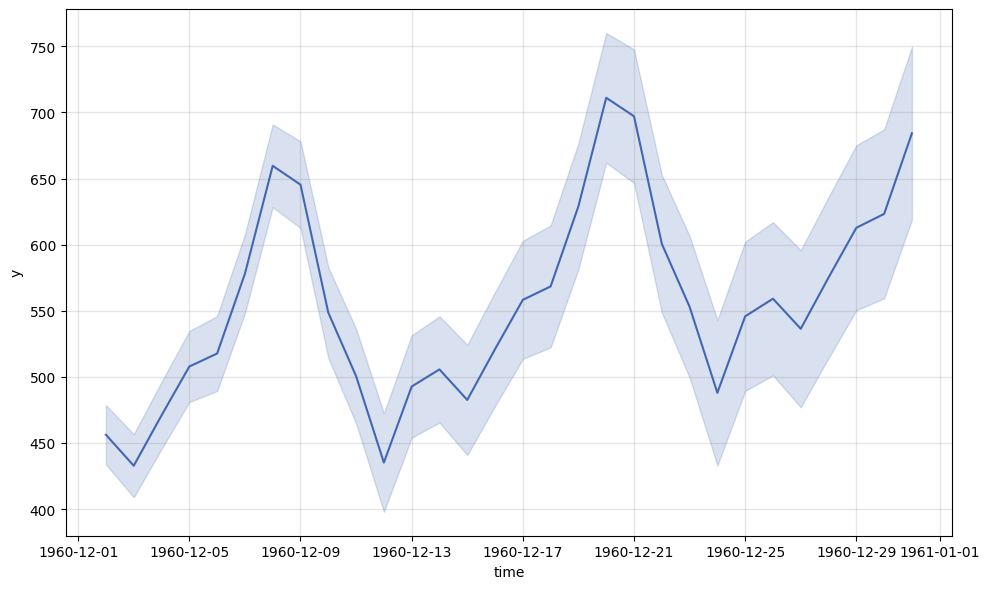

In [19]:
warnings.simplefilter(action='ignore')


holt_params = HoltWintersParams(
            trend="mul",
            damped=False,
            seasonal="add",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=air_passengers_ts, 
    params=holt_params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### lstm

In [20]:
from kats.models.lstm import LSTMParams, LSTMModel
import random

random.seed(10)

parameters_grid_search = [
{
    "name": "hidden_size",
    "type": "choice",
    "values": list(range(1,20)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "time_window",
    "type": "choice",
    "values": list(range(1,10)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "num_epochs",
    "type": "choice",
    "values": list(range(1,3)),
    "value_type": "int",
    "is_ordered": True,
},
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    lstm_params = LSTMParams(
        hidden_size= params['hidden_size'],
        time_window= params['time_window'],
        num_epochs = params['num_epochs']
    )
    model = LSTMModel(train_ts, lstm_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


# parameter_tuner_grid.generate_evaluate_new_parameter_values(
#     evaluation_function=evaluation_function
# )

# # Retrieve parameter tuning results

# parameter_tuning_results_grid = (
#     parameter_tuner_grid.list_parameter_value_scores()
# )



In [21]:
# min = parameter_tuning_results_grid['mean'].min()

# parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

<AxesSubplot: xlabel='time', ylabel='y'>

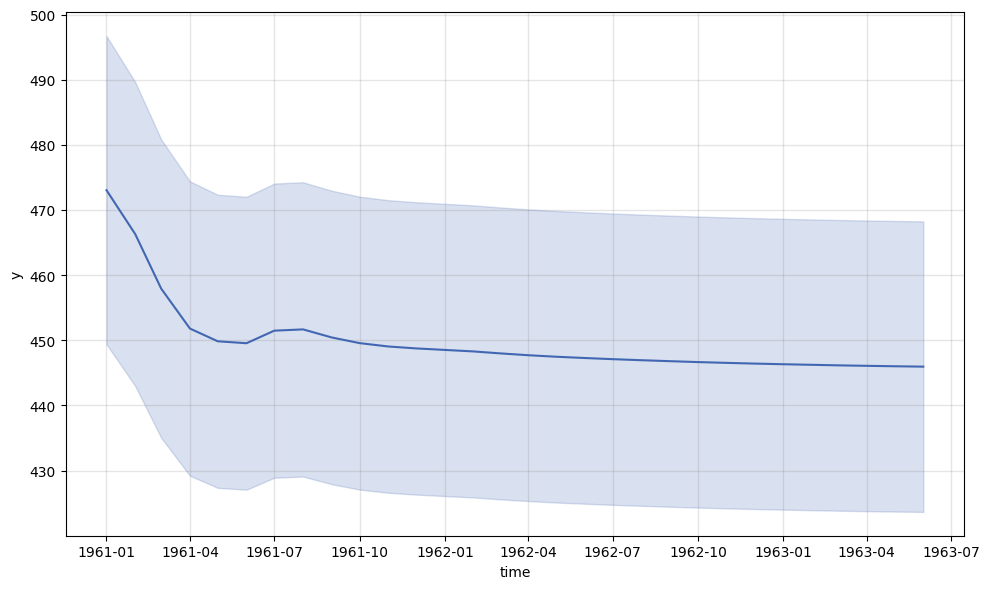

In [22]:
warnings.simplefilter(action='ignore')

lstm_params = LSTMParams(
            hidden_size=70,
            time_window=7,
            num_epochs=3
        )
m = LSTMModel(
    data=air_passengers_ts, 
    params=lstm_params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### thetha

<AxesSubplot: xlabel='time', ylabel='y'>

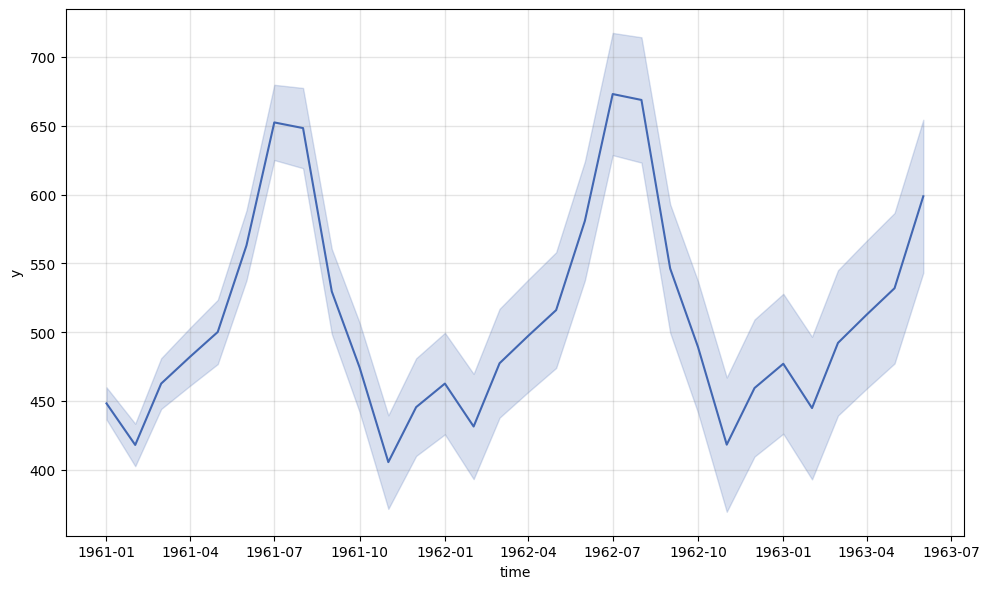

In [23]:
# No es necesario hacer un grid, sabemos que la estacionalidad es 12
from kats.models.theta import ThetaModel, ThetaParams
warnings.simplefilter(action='ignore')

theta_params = ThetaParams(
            m = 12
        )
m = ThetaModel(
    data=air_passengers_ts, 
    params=theta_params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### EVALUACIÓN DE LOS MODELOS 

#### Backtester simple

In [24]:
from kats.utils.backtesters import BackTesterSimple


backtester_simple_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']
# ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']


In [25]:
backtester_simple_sarima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= sarima_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=SARIMAModel)

backtester_simple_sarima.run_backtest()

backtester_simple_errors['sarima'] = {}
for error, value in backtester_simple_sarima.errors.items():
    backtester_simple_errors['sarima'][error] = value

In [26]:
backtester_simple_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= arima_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=ARIMAModel)

backtester_simple_arima.run_backtest()

backtester_simple_errors['arima'] = {}
for error, value in backtester_simple_arima.errors.items():
    backtester_simple_errors['arima'][error] = value

In [27]:
backtester_simple_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= prophet_params,
    train_percentage=80,
    test_percentage=20,
    model_class=ProphetModel)

backtester_simple_prophet.run_backtest()

backtester_simple_errors['prophet'] = {}
for error, value in backtester_simple_prophet.errors.items():
    backtester_simple_errors['prophet'][error] = value

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
backtester_simple_holt = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= holt_params,
    train_percentage=80,
    test_percentage=20,
    model_class=HoltWintersModel)

backtester_simple_holt.run_backtest()

backtester_simple_errors['holt'] = {}
for error, value in backtester_simple_holt.errors.items():
    backtester_simple_errors['holt'][error] = value

In [29]:
backtester_simple_lstm = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= lstm_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=LSTMModel)

backtester_simple_lstm.run_backtest()

backtester_simple_errors['lstm'] = {}
for error, value in backtester_simple_lstm.errors.items():
    backtester_simple_errors['lstm'][error] = value

In [30]:
backtester_simple_theta = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= theta_params,
    train_percentage=80,
    test_percentage=20,
    model_class=ThetaModel)

backtester_simple_theta.run_backtest()

backtester_simple_errors['theta'] = {}
for error, value in backtester_simple_theta.errors.items():
    backtester_simple_errors['theta'][error] = value

## Ensemble models

In [37]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
model_ensemble_params = EnsembleParams(
            [
                BaseModelParams("sarima",sarima_params),
                BaseModelParams("arima", arima_params),
                BaseModelParams("prophet", prophet_params),
                BaseModelParams("holtwinters", holt_params),   
                BaseModelParams("theta", theta_params)
                # BaseModelParams("lstm", lstm_params)
            ]
        )

### median

<AxesSubplot: xlabel='time', ylabel='y'>

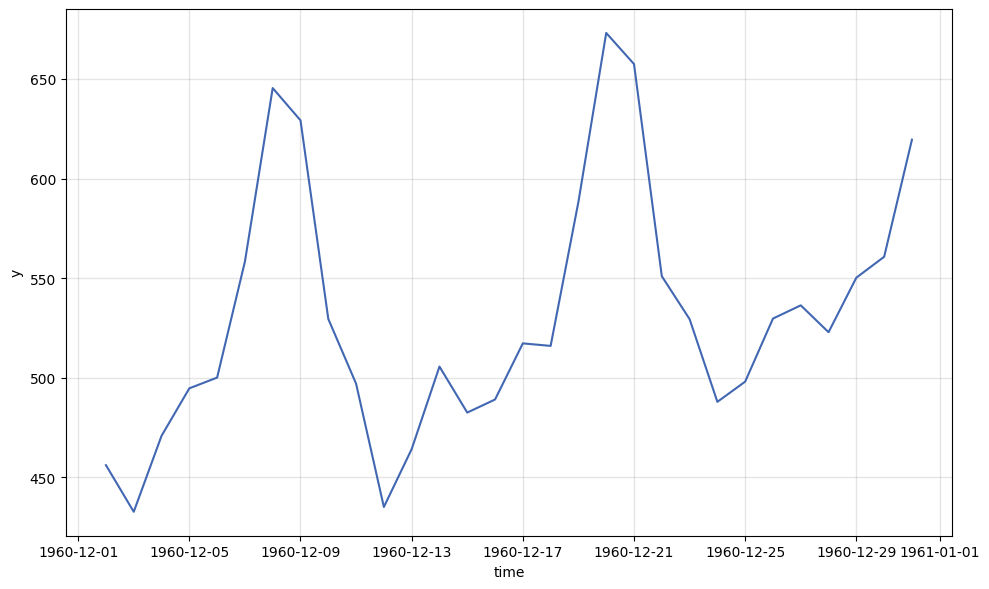

In [38]:
from kats.models.ensemble.median_ensemble import MedianEnsembleModel

m = MedianEnsembleModel(data = air_passengers_ts, 
                        params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)
m.plot()

### mean 

<AxesSubplot: xlabel='time', ylabel='y'>

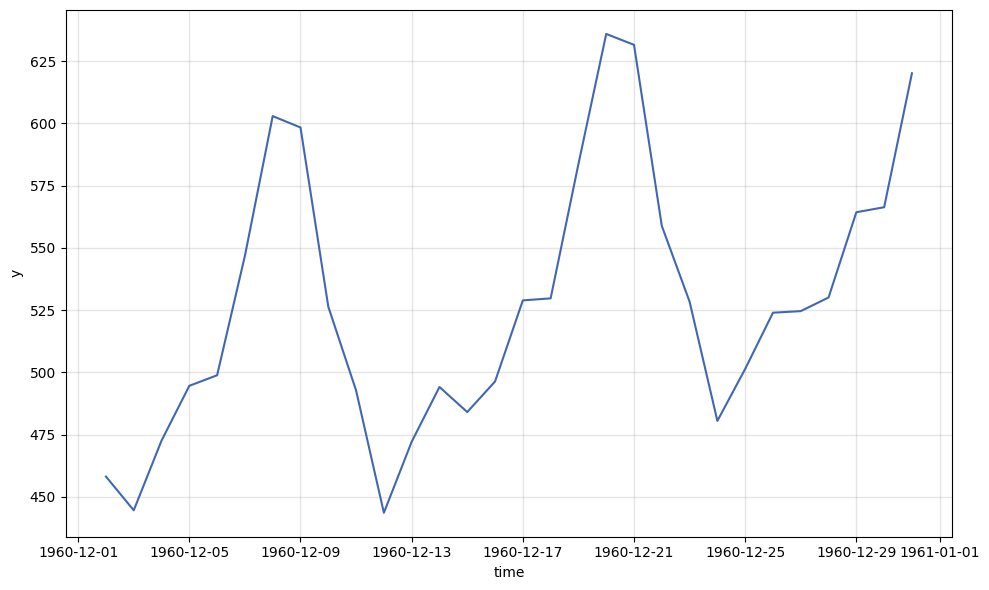

In [39]:
from kats.models.ensemble.mean_ensemble import MeanEnsembleModel

m = MeanEnsembleModel(data = air_passengers_ts, 
                    params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)
m.plot()

### weighted average

<AxesSubplot: xlabel='time', ylabel='y'>

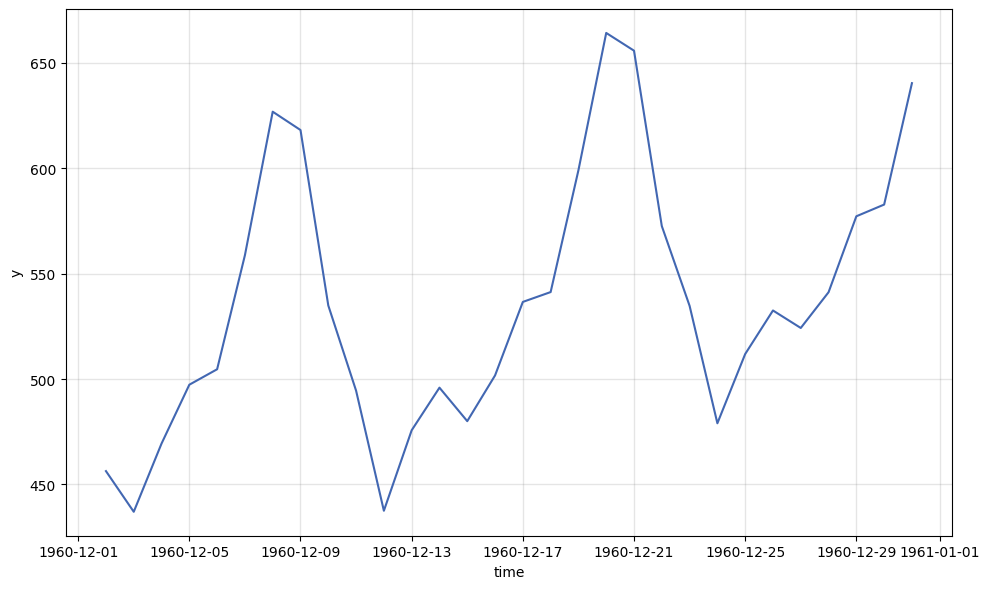

In [40]:
from kats.models.ensemble.weighted_avg_ensemble import WeightedAvgEnsemble

m = WeightedAvgEnsemble(data = air_passengers_ts, 
                        params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)

m.plot()

### bates&granger

<AxesSubplot: xlabel='time', ylabel='y'>

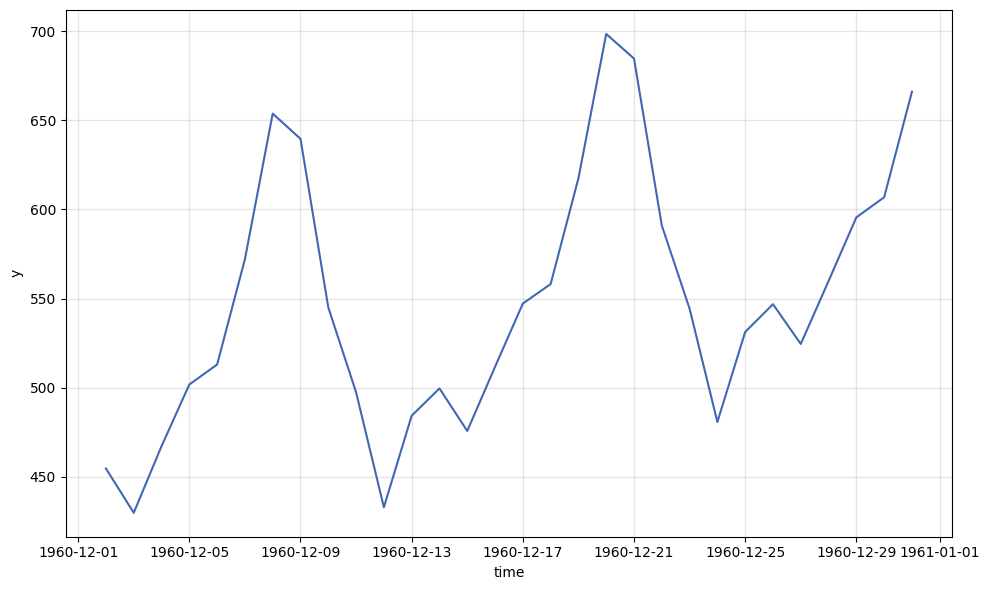

In [41]:
from kats.models.ensemble.bates_granger_ensemble import BatesGrangerEnsemble

m = BatesGrangerEnsemble(data = air_passengers_ts, 
                        params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)

m.plot()

##### Evaluación de modelos

In [42]:
backtester_ensemble_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']


In [43]:

backtester_ensemble_median = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20,
    model_class=MedianEnsembleModel)

backtester_ensemble_median.run_backtest()

backtester_ensemble_errors['median'] = {}
for error, value in backtester_ensemble_median.errors.items():
    backtester_ensemble_errors['median'][error] = value

In [44]:
backtester_ensemble_mean = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=MeanEnsembleModel)

backtester_ensemble_mean.run_backtest()

backtester_ensemble_errors['mean'] = {}
for error, value in backtester_ensemble_mean.errors.items():
    backtester_ensemble_errors['mean'][error] = value

In [45]:

backtester_ensemble_weighted_average = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=WeightedAvgEnsemble)

backtester_ensemble_weighted_average.run_backtest()

backtester_ensemble_errors['weighted_average'] = {}
for error, value in backtester_ensemble_weighted_average.errors.items():
    backtester_ensemble_errors['weighted_average'][error] = value

In [46]:

backtester_ensemble_bates_granger = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=BatesGrangerEnsemble)

backtester_ensemble_bates_granger.run_backtest()

backtester_ensemble_errors['bates&granger'] = {}
for error, value in backtester_ensemble_bates_granger.errors.items():
    backtester_ensemble_errors['bates&granger'][error] = value

## COMPARATIVA FINAL 

In [47]:
pd.DataFrame.from_dict(backtester_simple_errors) 

,sarima,arima,prophet,holt,lstm,theta
mae,19.467027,54.349207,39.277283,43.389170,76.529880,30.149698
mape,0.044252,0.120353,0.096695,0.107816,0.159733,0.066698
mase,0.448254,1.251462,0.904411,0.999093,1.762201,0.694236
mse,638.541223,5052.656369,1966.272976,2324.818044,10422.550301,1454.138807
rmse,25.269373,71.082040,44.342677,48.216367,102.090892,38.133172
smape,0.044254,0.124585,0.092553,0.101006,0.180284,0.069523


In [48]:
pd.DataFrame.from_dict(backtester_ensemble_errors) 

,median,mean,weighted_average,bates&granger
mae,28.274667,27.427984,23.846899,30.368845
mape,0.068303,0.064869,0.058131,0.076241
mase,0.651061,0.631565,0.549106,0.699283
mse,1156.437484,1097.130234,785.242877,1137.117813
rmse,34.006433,33.122956,28.022185,33.721178
smape,0.066537,0.063895,0.056690,0.072746


## PLOTING

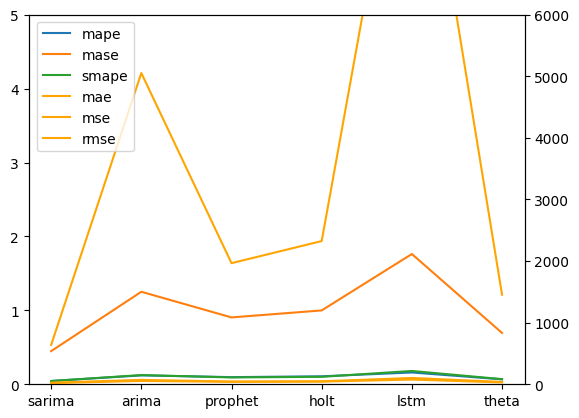

In [49]:
df = pd.DataFrame.from_dict(backtester_simple_errors).T

df[["mape","mase","smape"]]
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set_title("Product Sales and Profits")

fig, ax = plt.subplots()

ax.plot(df[["mape","mase","smape"]], label = ["mape","mase","smape"] )
ax.set_ylim(0, 5)

ax2 = ax.twinx()

ax2.plot(df[["mae","mse","rmse"]], c="orange", label = ["mae","mse","rmse"])
ax2.set_ylim(0, 6000)

fig.legend(bbox_to_anchor=(.3, .88))

plt.show()

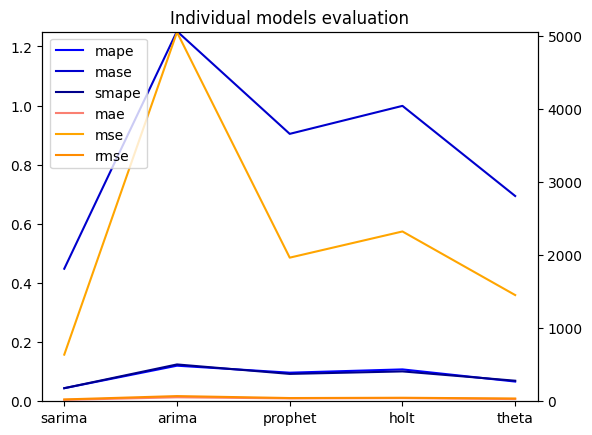

In [50]:
df = pd.DataFrame.from_dict(backtester_simple_errors).drop(['lstm'], axis=1).T

colors = ['blue','mediumblue','darkblue','salmon','orange','darkorange']
col = ["mape","mase","smape","mae","mse","rmse"]

fig, ax = plt.subplots()

for i, column in enumerate(df[["mape","mase","smape"]].columns):
    ax.plot(
        df[col[i]] , 
        color=colors[i],
        label = col[i]
    )

ax.set_ylim(0, 1.25)

ax2 = ax.twinx()

for i, column in enumerate(df[["mae","mse","rmse"]].columns):
    ax2.plot(
        df[col[i+3]] , 
        color=colors[i+3],
        label = col[i+3]
    )

ax2.set_ylim(0, 5060)

fig.legend(bbox_to_anchor=(.3, .88))

ax.set_title('Individual models evaluation')

plt.show()

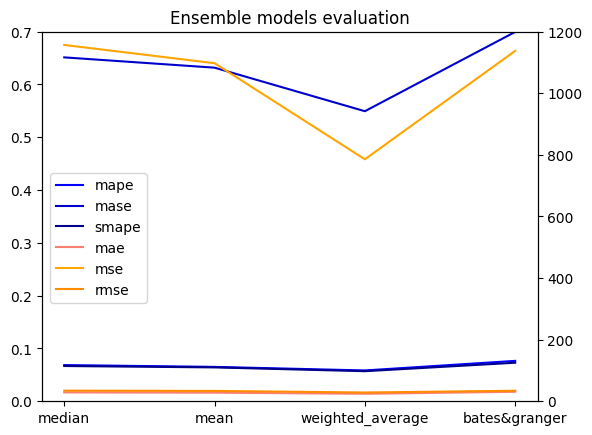

In [51]:
df = pd.DataFrame.from_dict(backtester_ensemble_errors).T

fig, ax = plt.subplots()

for i, column in enumerate(df[["mape","mase","smape"]].columns):
    ax.plot(
        df[col[i]] , 
        color=colors[i],
        label = col[i]
    )

ax.set_ylim(0, 0.7)

ax2 = ax.twinx()

for i, column in enumerate(df[["mae","mse","rmse"]].columns):
    ax2.plot(
        df[col[i+3]] , 
        color=colors[i+3],
        label = col[i+3]
    )

ax2.set_ylim(0, 1200)

fig.legend(bbox_to_anchor=(.3, .6))

ax.set_title('Ensemble models evaluation')

plt.show()

In [52]:
# TODOS JUNTOS 
df_complete = pd.concat([pd.DataFrame.from_dict(backtester_simple_errors).drop(['lstm'], axis=1),pd.DataFrame.from_dict(backtester_ensemble_errors)], axis=1).T

# df_complete.index = ['s','a','p','h','t','me','wa','bg']
# df_complete.index[6] = 'weigh_avg'
# df_complete.index[7] = 'bat_gr'
df_complete.index = ['sarima', 'arima', 'prophet', 'holt', 'theta', 'median','mean','weigh_avg', 'bat_gr']

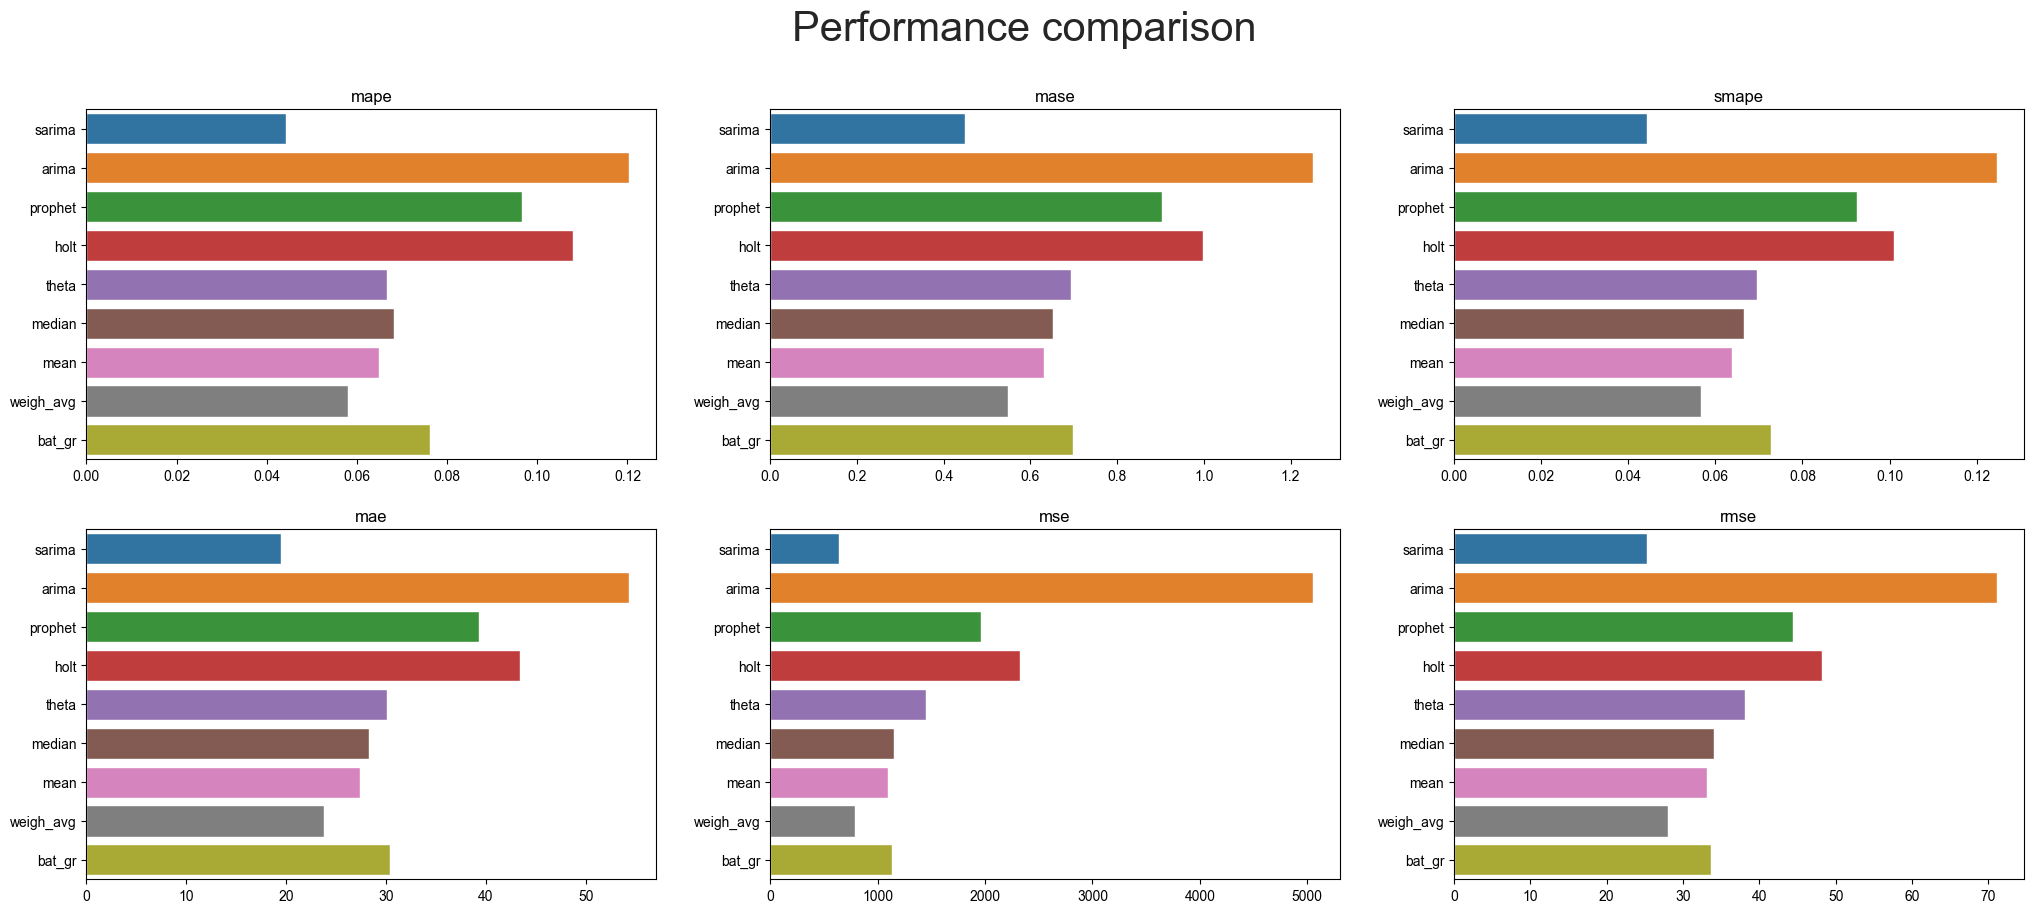

In [53]:
import seaborn as sns

def comparative_barplot(err,i,j):
    sns.set_style("darkgrid")
    p = sns.barplot(
        x = err,
        y = df_complete.index,
        data = df_complete,
        ax = ax[i][j]
        
    )
    p.set(title= err)
    p.set_xlabel('')

error = ["mape","mase","smape","mae","mse","rmse"]

fig, ax = plt.subplots(2, 3)
# plt.rc('font', size = 15)
# fig.suptitle('Comparison of the different types of errors', fontsize = 40, fontfamily ='DejaVu Sans' )


i = 0
for e in error[0:3]:
    comparative_barplot(e,0,i) 
    i = i+1

i = 0
for e in error[3:7]:
    comparative_barplot(e,1,i) 
    i = i+1

# fig.tight_layout()
fig.set_size_inches(25, 10)
fig.suptitle('Performance comparison', fontsize = 30)

plt.savefig('../images/comparative_errors', bbox_inches='tight')